<a id="notations"></a>

# Process design of NOx, Gas Absorption Packed Column 
 In the commercial nitric acid plant, the mixture of ammonia with air is passed over catalyst gauze at temperature and pressure in the range of 800-850°C and 0.3 2 MPa, respectively

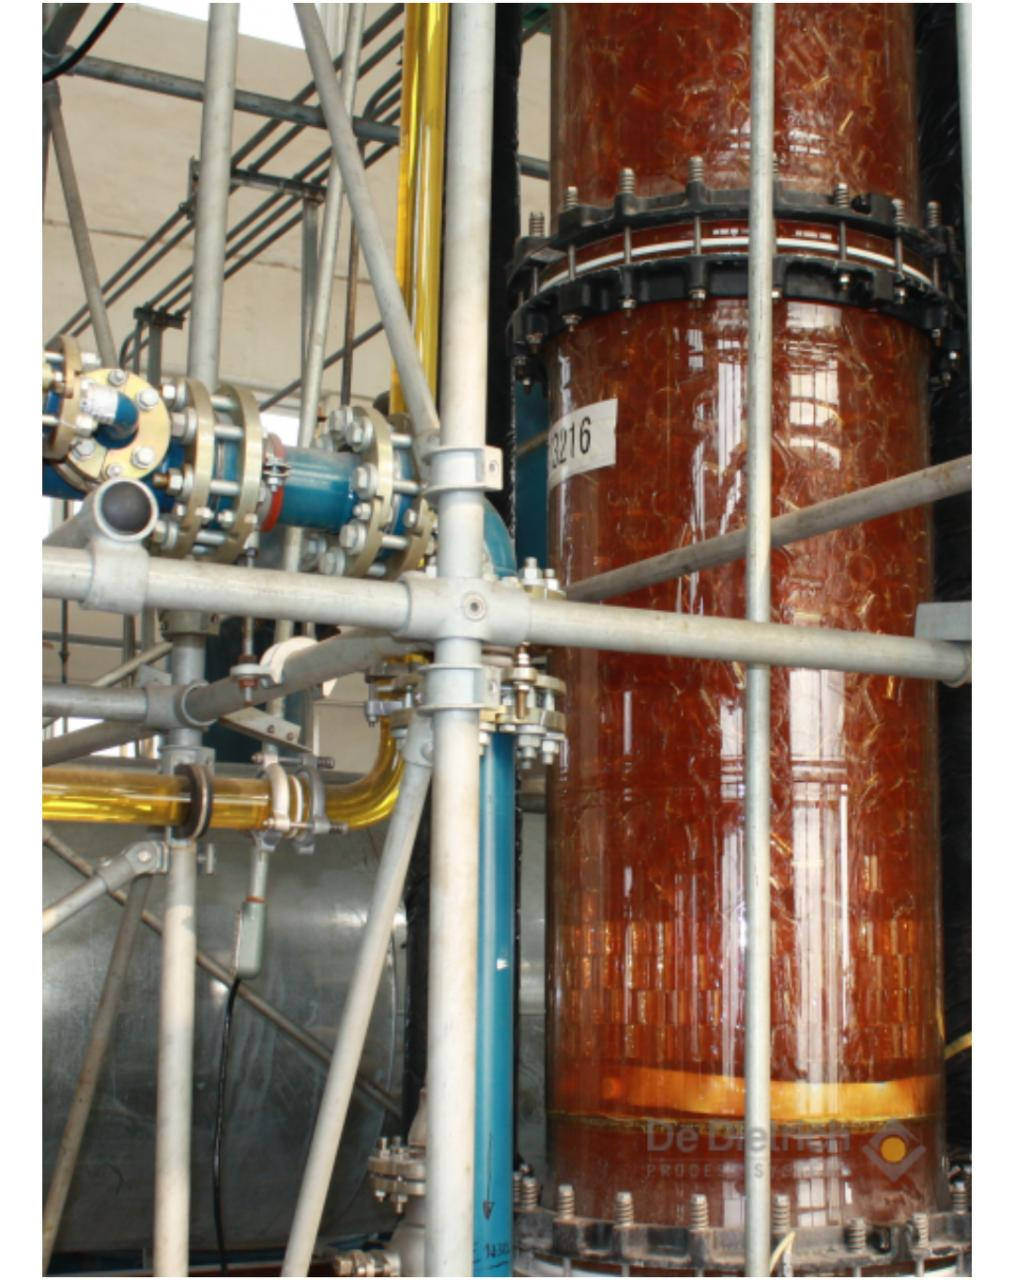

In [100]:
from IPython.display import Image
Image(filename="no2.jpg",width=400,height=400) 

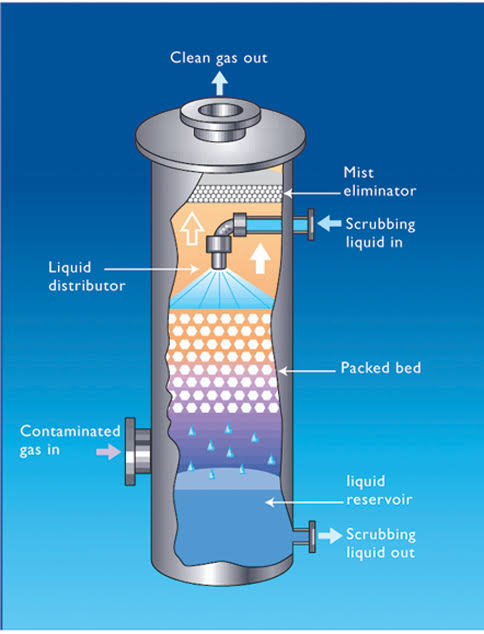

In [101]:
from IPython.display import Image
Image(filename="no1.jpg",width=400,height=400) 

In [102]:
import scipy
import scipy.integrate as scint
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import derivative

Consider First Component as Nitric Oxide and Second Component as Oxygen gas coming from the bottom of the tower ,While Water input is from the top

 Mass balance across a differential height dh at height h from the bottom is given as: 
dy1bydz=kGa*S/Gs*(1-y1)**2*scipy.log((1-y1)/(1-H1*x1i))
    dy2bydz=kGa*S/Gs*(1-y2)**2*scipy.log((1-y2)/(1-H2*x2i))
    
    https://youtu.be/OGxBvaxSzyk

In [103]:
Pressure = 0.3 #MPa
Temperature = 825 
D=0.48 #Diameter 
Gsi=169 #Input Gas Flow Rate in mol/s
y1in=0.04 #mole fractions
y2in=0.04 #mole fractions
Gs=(1-y1in-y2in)*Gsi
Ls=240 #input water flow rate in mol/s


In [104]:
rhoG=3.92
gMW=Gs/Gsi*28.81+y1in*28.014+y2in*15.999
Qg=Gsi*gMW*1e-3/1.225
S=scipy.pi*0.25*D**2
Vg=Qg/S
kGa=((0.13 / rhoG) - (0.065/ rhoG ** 2))/10
neuL= 23
kLa=2.6*10**-2
H1=1.9*10
H2=1.3*10
H=3

In [105]:
print(kLa,kGa)

0.026000000000000002 0.0028933256976259895


In [106]:
#finding x1i
def findx1i(x1,y1,x1i):
    x1i=(y1+kLa/kGa*x1)/(kLa/kGa+H1)
    return x1i

In [107]:
#finding x2i
def findx2i(x2,y2,x2i):
    x2i=(y2+kLa/kGa*x2)/(kLa/kGa+H2)
    return x2i

In [108]:
def model(SV,z,obj):
    [x1,x2,y1,y2]=SV
    D=obj.D
    S=obj.S
    Ls=obj.Ls
    H1=obj.H1
    H2=obj.H2
    H=obj.H
    x1i=0.005
    x2i=0.005
    dx1bydz=kLa*S/Ls*(1-x1)**2*scipy.log((1-x1)/(1-findx1i(x1,y1,x1i)))
    dx2bydz=kLa*S/Ls*(1-x2)**2*scipy.log((1-x2)/(1-findx2i(x2,y2,x2i)))
    dy1bydz=kGa*S/Gs*(1-y1)**2*scipy.log((1-y1)/(1-H1*x1i))
    dy2bydz=kGa*S/Gs*(1-y2)**2*scipy.log((1-y2)/(1-H2*x2i))
    return [dx1bydz,dx2bydz,dy1bydz,dy2bydz]

In [109]:
def get_boundary_residuals(SV0, obj):
    z = scipy.array([0, obj.H])
    trial_solution = scint.odeint(model, SV0, z, args = (obj,))
    SVi = trial_solution[0]
    SVb = trial_solution[-1]
    error = []
    k = 0
    for ic in obj.initial_conditions:
        error.append(ic - SVi[k])
        k = k + 1
    for bc in obj.boundary_conditions:
        error.append(bc - SVb[k])
        k = k +  1
    return error

In [110]:
class absorption:
    def __init__(self):
        self.D=0.48
        self.S=scipy.pi*0.25*D**2
        self.Ls=240
        self.H1=299
        self.H2=354
        self.H=3
        self.y1in=0.04
        self.y2in=0.04
        self.x1in=0
        self.x2in=0
    def solve(self):
        self.x=scipy.linspace(0,self.H,10)
        self.initial_conditions=[self.y1in,self.y2in]
        self.boundary_conditions=[self.x1in,self.x2in]
        SV0=self.initial_conditions + self.boundary_conditions
        shooting_method_solution = scopt.least_squares(get_boundary_residuals,
                                                      SV0,
                                                      args = (self,))
        SV0=shooting_method_solution.x
        solution = scint.odeint(model, SV0, self.x, args = (self,))
        print(solution)
        self.solution=pd.DataFrame({
            "x":self.x,
            "x1":solution[:,0],
            "x2":solution[:,1],
            "y1":solution[:,2],
            "y2":solution[:,3],
            
        }
        
        )
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.solution["x"], 
                self.solution["x1"],
                'r', label = "NO")
        ax.plot(self.solution["x"],
               self.solution["x2"],
               'b', label="Oxygen")
        ax.legend()
        ax.xaxis.label.set_text("Height Along Hex in m")
        ax.yaxis.label.set_text("mole fraction")
        ax.title.set_text("Concentration Profiles")

In [111]:
# cchex1 is object of absorption
cchex1 = absorption()
cchex1.H = 5

In [97]:
cchex1.solve()

In [98]:
cchex1.solution

,x,x1,x2,y1,y2
0,0.000000,0.040000,0.040000,-1.183999e-05,-4.400659e-06
1,0.555556,0.040000,0.040000,-1.052441e-05,-3.911692e-06
2,1.111111,0.039999,0.040000,-9.208838e-06,-3.422725e-06
3,1.666667,0.039999,0.039999,-7.893272e-06,-2.933760e-06
4,2.222222,0.039999,0.039999,-6.577712e-06,-2.444797e-06
5,2.777778,0.039999,0.039999,-5.262158e-06,-1.955835e-06
6,3.333333,0.039998,0.039999,-3.946610e-06,-1.466874e-06
7,3.888889,0.039998,0.039998,-2.631067e-06,-9.779146e-07
8,4.444444,0.039998,0.039998,-1.315531e-06,-4.889566e-07
9,5.000000,0.039997,0.039998,9.693377e-16,3.530010e-18


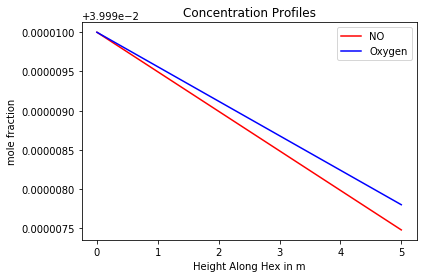

In [89]:
cchex1.plot()

In [73]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='OGxBvaxSzyk',width=500,height=300)

### <font color='green'>Prepared by :- Apurva Pawar


<font color='Purple'><font size='5'>THANK YOU

<font color='Brown'>*To Revisit the entire Solution or to move to the top* </font>[Click here](#notations)